In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import yfinance as yf
import datetime

from valueinvesting import utils as utils

# 1. Load raw input
## Hardcoded block

In [2]:
evaluate_last_X_years = True
X=10
currency_pair = 'USD=X'
numbers_in_currency = 'USD'
share_name = 'SMG'

# 1.1 Calculate Share numbers from total distributed dividend (CFS) and dividend amount

# 1.2. Raw input statement data

In [3]:
route = f"../data/input/{share_name}_data.csv"
data = pd.read_csv(route, sep=';', parse_dates=['date', 'real_date'])
# replace -, extend missing 0-s, fix datatype
data = utils.replace_format_input(data)

In [4]:
owned_shares = pd.read_csv('../data/extras/owned_stocks.csv', sep=';', parse_dates=['date'])
owned_shares = owned_shares.loc[(owned_shares['stock'] == share_name) & (owned_shares['active'] == 'yes')]

## (OPTIONAL) Time Filtering - Last 7 years daat

In [5]:
if evaluate_last_X_years:
    data = data[data['date'] > datetime.datetime.today() - datetime.timedelta(days=X*366+93)]
    data = data.reset_index(drop=True)

data.head()

,date,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,curr_assets,goodwill,...,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,shares,real_date
0,2014-09-30,191,-192,-1,-35,89,224,385,935,351,...,193,0,92,545,692,1505,207,-19,62.7,2014-11-29
1,2014-12-31,170,-163,7,-75,130,185,683,1126,364,...,220,0,37,422,1133,1818,-267,-15,62.2,2015-02-09
2,2015-03-31,1072,-647,425,139,55,682,596,1864,372,...,300,0,318,985,1211,2454,-382,-14,62.2,2015-05-10
3,2015-06-30,1111,-722,389,115,80,437,416,1440,431,...,316,0,316,1343,738,2338,673,-13,62.2,2015-08-09
4,2015-09-30,19,-26,-7,-51,71,158,396,1119,284,...,193,0,133,619,1025,1907,223,-21,62.2,2015-11-29


## Calculate date when quaterly reports could be available

In [6]:
data = utils.calculate_real_date(data)

# 2. Filter out unnecesary columns

In [7]:
data = utils.filter_raw_data(data)
data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,intangible_assets,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex
35,2023-07-01,2023-08-10,56.0,1119,-880,239,44,27,718,885,...,560,4454,366,0,451,1329,2613,4320,563,-22
36,2023-09-30,2023-11-29,56.0,375,-408,-33,-468,32,304,880,...,437,3414,271,0,52,774,2542,3681,535,-19
37,2023-12-31,2024-02-09,56.0,410,-354,56,-81,10,288,1170,...,433,3716,333,0,55,764,2954,4102,-343,-38
38,2024-04-01,2024-04-29,57.4,1525,-986,549,157,65,876,824,...,429,3924,440,0,58,1060,2760,4175,304,-16
39,2024-06-30,2024-07-29,58.0,1202,-850,354,132,279,504,606,...,425,3489,316,0,53,854,2436,3489,510,-13


## Pull historical average USD national currency rates and add to the dataframe

In [8]:
if currency_pair != 'USD=X':
    data['usd_nat_currency'] = utils.daily_price(
        ticker=currency_pair,
        end=data['date'],
        days_earlier=90
        )
else:
    data['usd_nat_currency'] = [1 for x in range(len(data))]

# drop rows, when USD rates wasn't available
data = data[data['usd_nat_currency'].notna()]

data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
35,2023-07-01,2023-08-10,56.0,1119,-880,239,44,27,718,885,...,4454,366,0,451,1329,2613,4320,563,-22,1
36,2023-09-30,2023-11-29,56.0,375,-408,-33,-468,32,304,880,...,3414,271,0,52,774,2542,3681,535,-19,1
37,2023-12-31,2024-02-09,56.0,410,-354,56,-81,10,288,1170,...,3716,333,0,55,764,2954,4102,-343,-38,1
38,2024-04-01,2024-04-29,57.4,1525,-986,549,157,65,876,824,...,3924,440,0,58,1060,2760,4175,304,-16,1
39,2024-06-30,2024-07-29,58.0,1202,-850,354,132,279,504,606,...,3489,316,0,53,854,2436,3489,510,-13,1


## Convert USD values related to IS, BS, CFS to national currency

In [9]:
# convert columns into national currency if necessary
if numbers_in_currency == 'USD':
    data_nat_curr = utils.convert_national_currency(input_data=data, currency=data)
else:
    data_nat_curr = data.copy()
data_nat_curr.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
35,2023-07-01,2023-08-10,56.0,1119.0,-880.0,239.0,44.0,27.0,718.0,885.0,...,4454.0,366.0,0.0,451.0,1329.0,2613.0,4320.0,563.0,-22.0,1
36,2023-09-30,2023-11-29,56.0,375.0,-408.0,-33.0,-468.0,32.0,304.0,880.0,...,3414.0,271.0,0.0,52.0,774.0,2542.0,3681.0,535.0,-19.0,1
37,2023-12-31,2024-02-09,56.0,410.0,-354.0,56.0,-81.0,10.0,288.0,1170.0,...,3716.0,333.0,0.0,55.0,764.0,2954.0,4102.0,-343.0,-38.0,1
38,2024-04-01,2024-04-29,57.4,1525.0,-986.0,549.0,157.0,65.0,876.0,824.0,...,3924.0,440.0,0.0,58.0,1060.0,2760.0,4175.0,304.0,-16.0,1
39,2024-06-30,2024-07-29,58.0,1202.0,-850.0,354.0,132.0,279.0,504.0,606.0,...,3489.0,316.0,0.0,53.0,854.0,2436.0,3489.0,510.0,-13.0,1


# 3. Calculate input to Value Raios (eps, bv per share, fcf)
## filter out unwanted columns

In [10]:
filtered_nat_curr = utils.calculate_input_value_ratios(data_nat_curr)

## Calculate input values to value ratios

In [11]:
ratios_nat_curr = utils.ratios_input_filter(filtered_nat_curr)

## Calculate performance parameters (current ratio, ROA, ROE, margins, D/E)

In [12]:
ratios_nat_curr = utils.evaluate_performance(input=filtered_nat_curr, output=ratios_nat_curr)

# 4. Pull historical share prices and merge with sattement data

In [13]:
# pull weekly share prices and merge with the value ratios
merged_nat_curr = utils.add_share_prices_to_value_ratios(share_name, data, ratios_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,equity_ratio,debt_ratio,acc_rec_ratio,acc_pay_ratio,cash_turnover,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe
0,2014-12-01,46.786503,2014-09-30,191.0,0.0,8.819777,62.7,0.0,0.0,89.0,...,0.268707,0.731293,0.0,0.0,0.0,0.0,-0.005236,-0.183246,0.0,0.0
1,2014-12-08,45.607330,2014-09-30,191.0,0.0,8.819777,62.7,0.0,0.0,89.0,...,0.268707,0.731293,0.0,0.0,0.0,0.0,-0.005236,-0.183246,0.0,0.0
2,2014-12-15,46.249157,2014-09-30,191.0,0.0,8.819777,62.7,0.0,0.0,89.0,...,0.268707,0.731293,0.0,0.0,0.0,0.0,-0.005236,-0.183246,0.0,0.0
3,2014-12-22,46.749187,2014-09-30,191.0,0.0,8.819777,62.7,0.0,0.0,89.0,...,0.268707,0.731293,0.0,0.0,0.0,0.0,-0.005236,-0.183246,0.0,0.0
4,2014-12-29,46.122280,2014-09-30,191.0,0.0,8.819777,62.7,0.0,0.0,89.0,...,0.268707,0.731293,0.0,0.0,0.0,0.0,-0.005236,-0.183246,0.0,0.0


# Calculate price ratios (P/E, P/B, P/S, P/FCF)

In [14]:
merged_nat_curr = utils.price_ratios(merged_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,pfcf_ratio
0,2014-12-01,46.786503,2014-09-30,191.0,0.0,8.819777,62.7,0.0,0.0,89.0,...,0.0,-0.005236,-0.183246,0.0,0.0,inf,5.304726,inf,inf,inf
1,2014-12-08,45.607330,2014-09-30,191.0,0.0,8.819777,62.7,0.0,0.0,89.0,...,0.0,-0.005236,-0.183246,0.0,0.0,inf,5.171030,inf,inf,inf
2,2014-12-15,46.249157,2014-09-30,191.0,0.0,8.819777,62.7,0.0,0.0,89.0,...,0.0,-0.005236,-0.183246,0.0,0.0,inf,5.243801,inf,inf,inf
3,2014-12-22,46.749187,2014-09-30,191.0,0.0,8.819777,62.7,0.0,0.0,89.0,...,0.0,-0.005236,-0.183246,0.0,0.0,inf,5.300496,inf,inf,inf
4,2014-12-29,46.122280,2014-09-30,191.0,0.0,8.819777,62.7,0.0,0.0,89.0,...,0.0,-0.005236,-0.183246,0.0,0.0,inf,5.229416,inf,inf,inf


# Calculate Dividend yield and currency-share price correlation

In [15]:
# get daily historical USD-national currency rates
usd_nat_curr = utils.get_historical_currency_rate(currency_pair, merged_nat_curr)

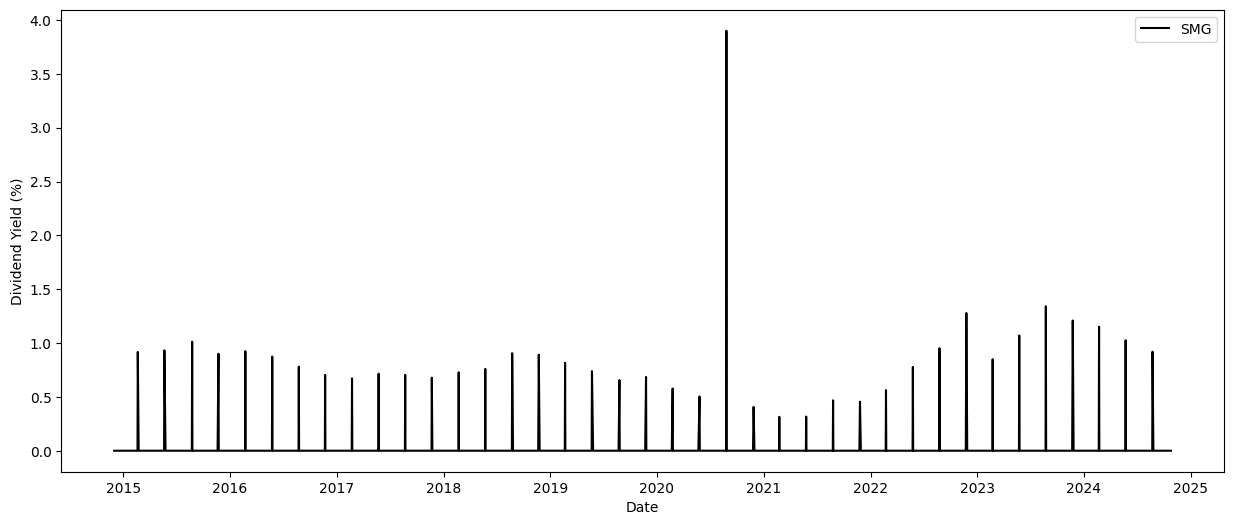

In [16]:
# get share prices and dividend yield data
ticker_all_price = utils.get_historical_share_dividend(share_name, merged_nat_curr)

currency_rate   NaN
share_price     NaN
Name: share_price, dtype: float64


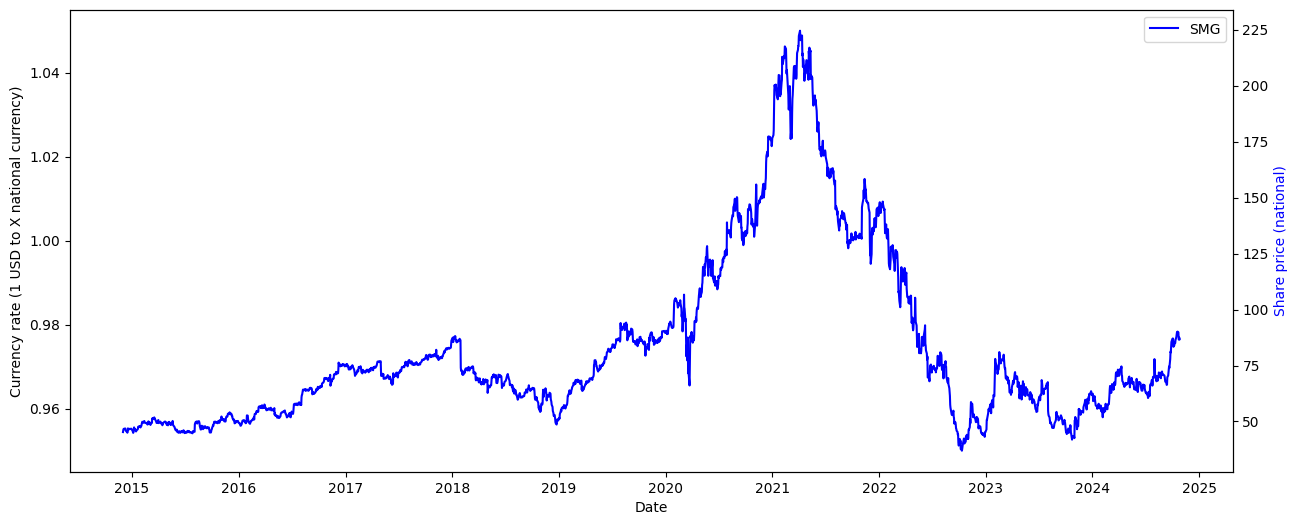

In [17]:
# Pearson's correlation coefficient between share price and USD - national currency rate
utils.get_currency_share_price_correlation(share_name, usd_nat_curr, ticker_all_price)

# Share price and value ratios

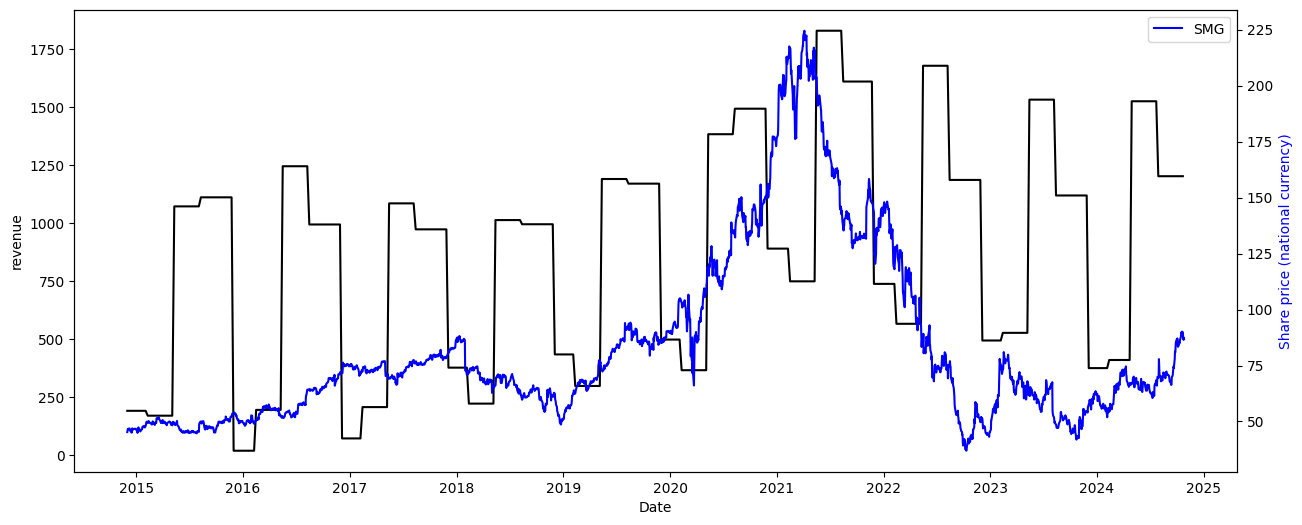

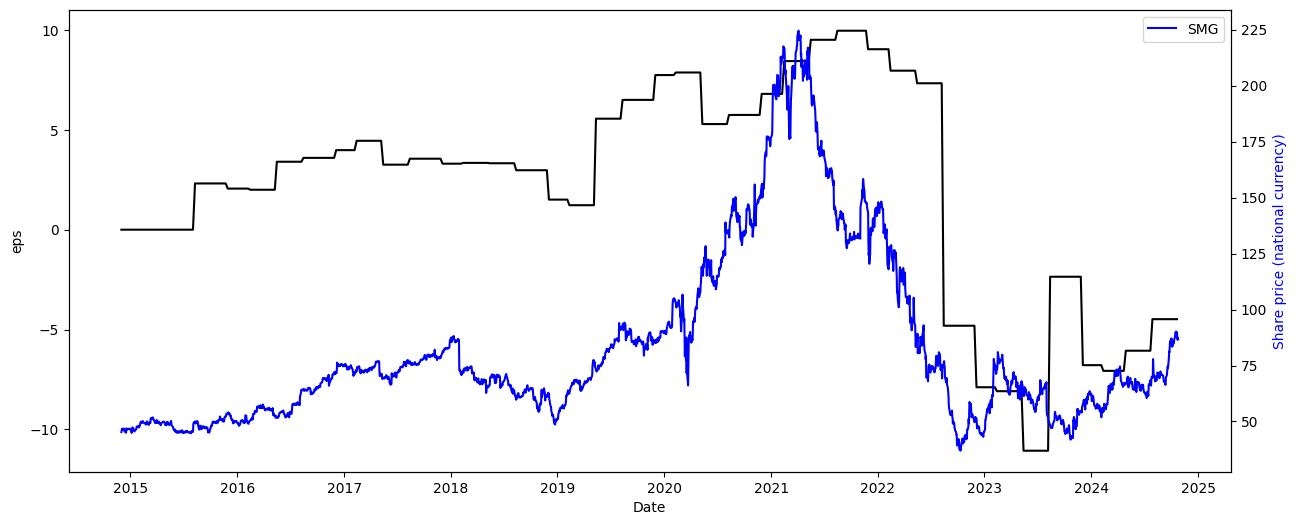

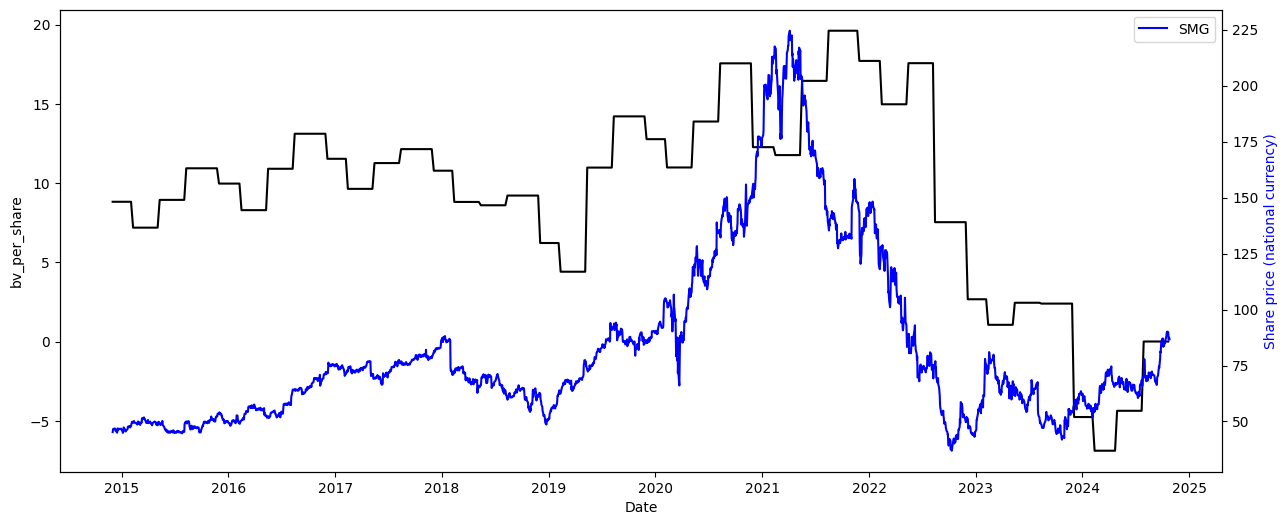

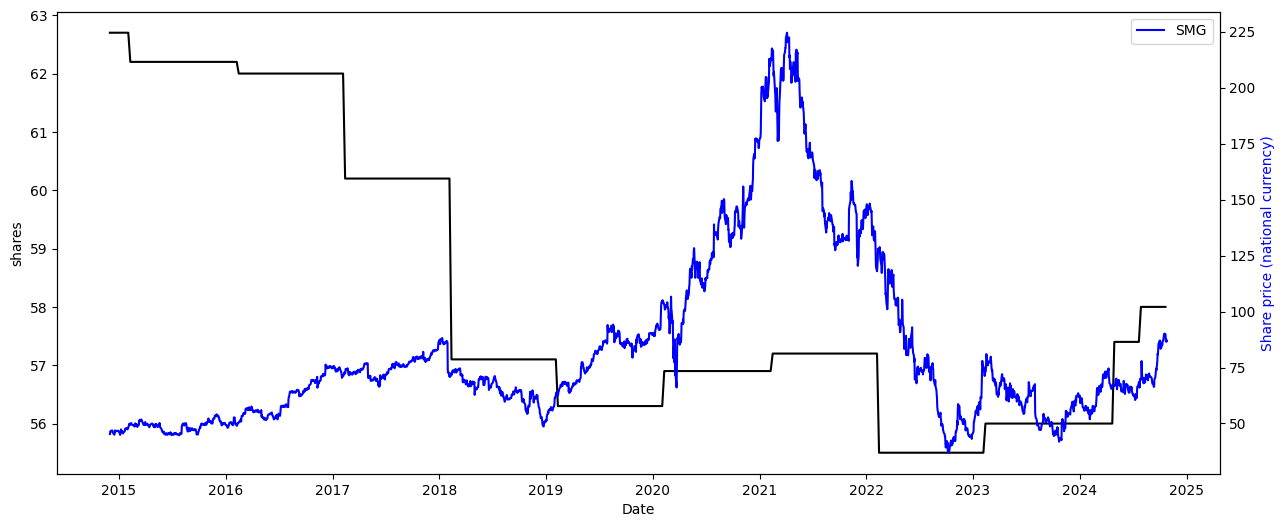

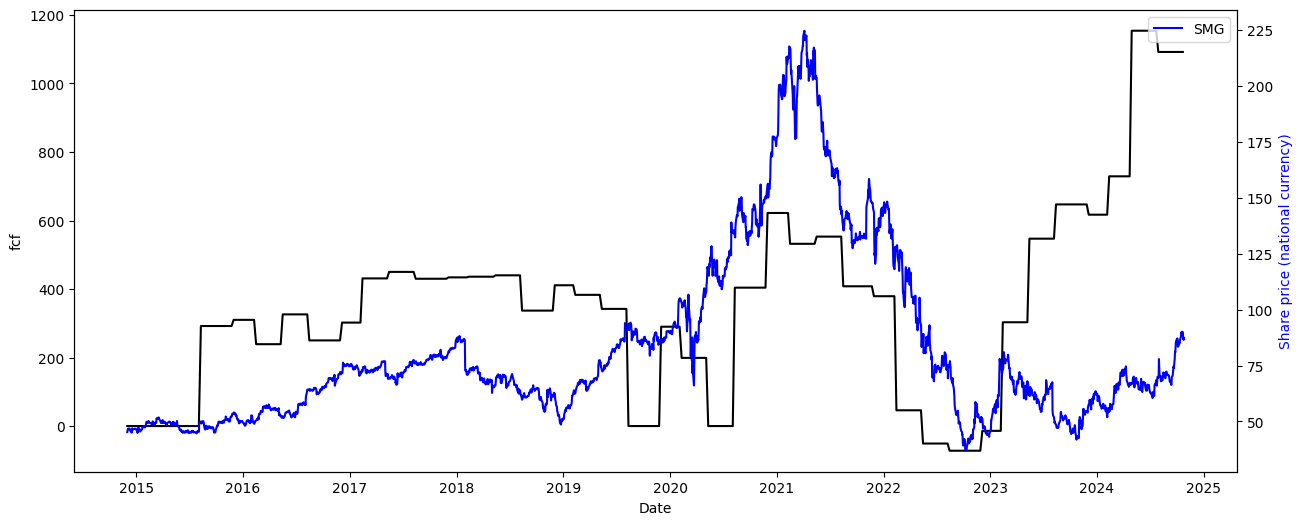

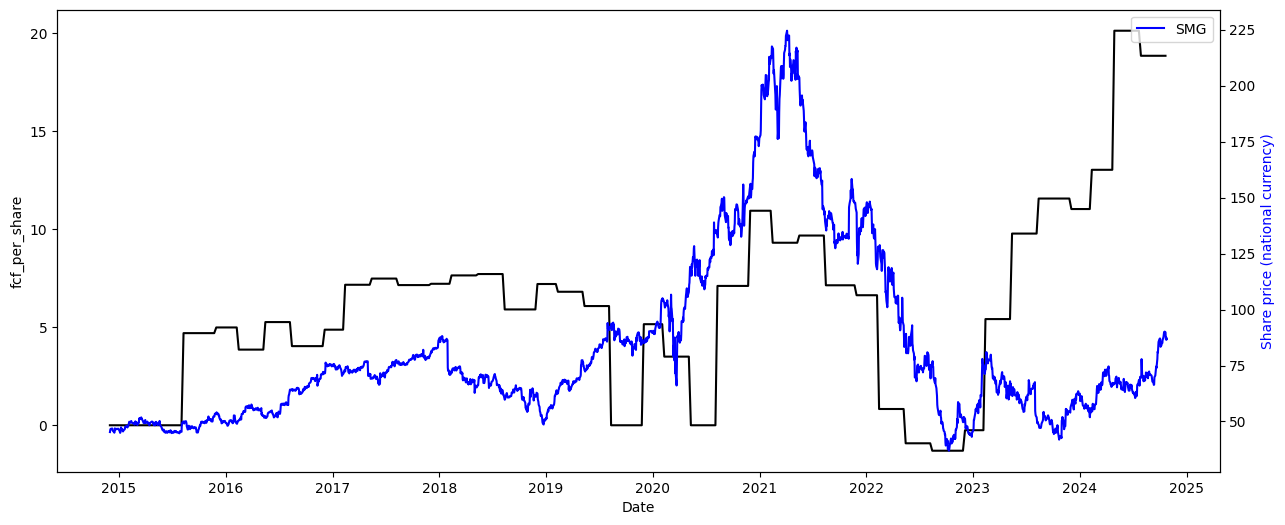

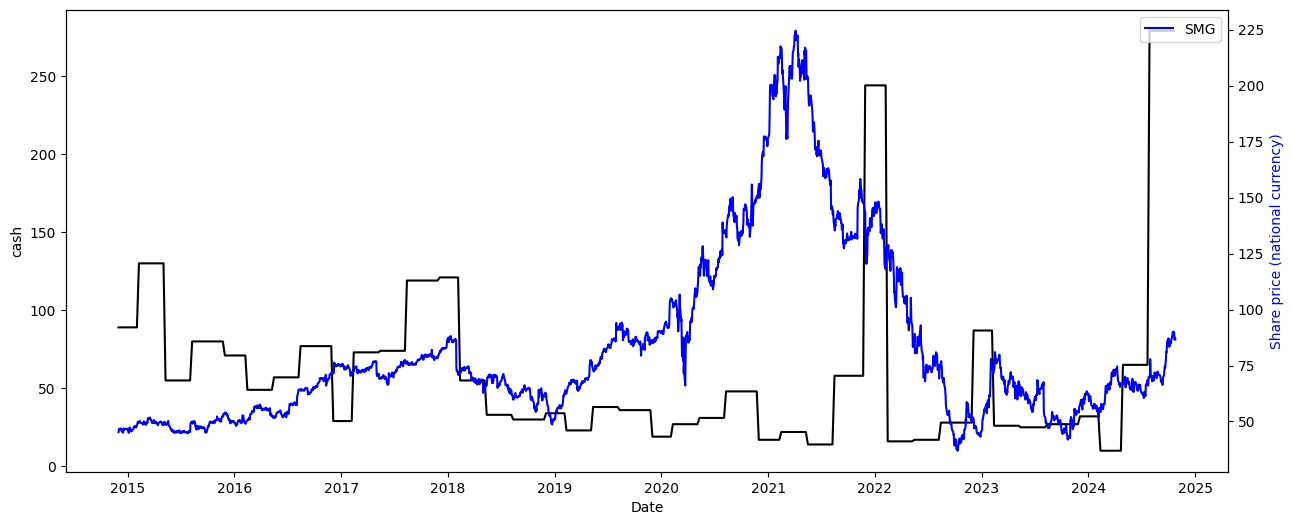

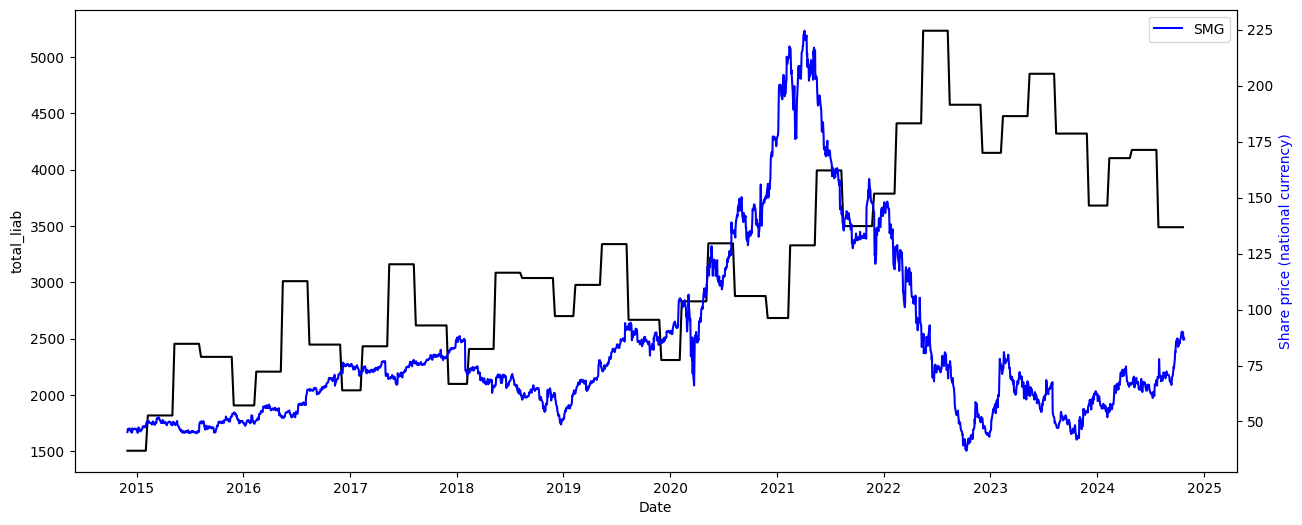

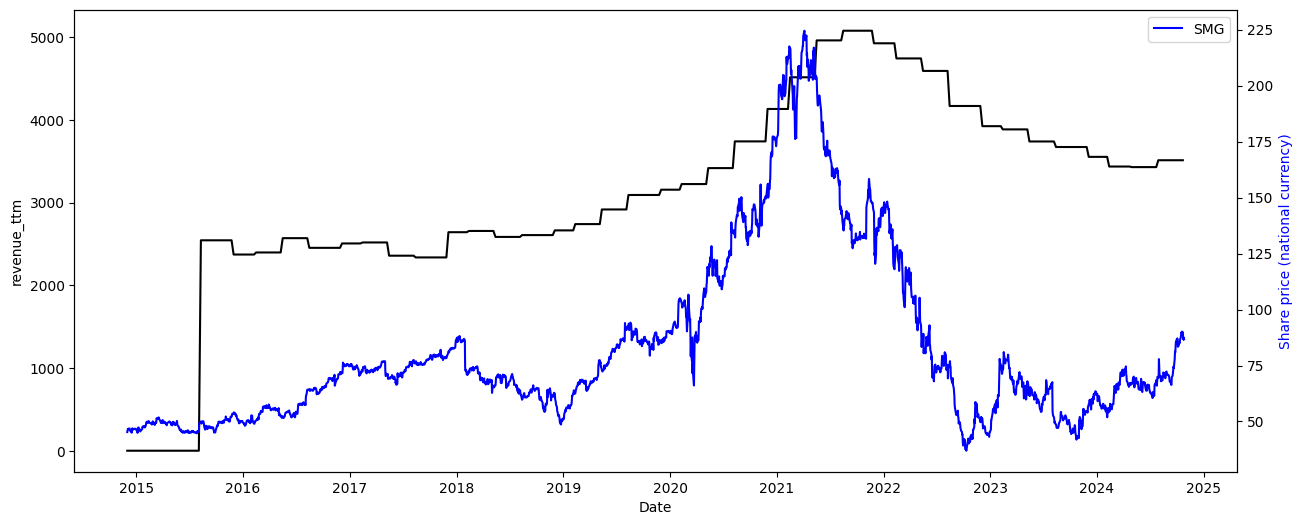

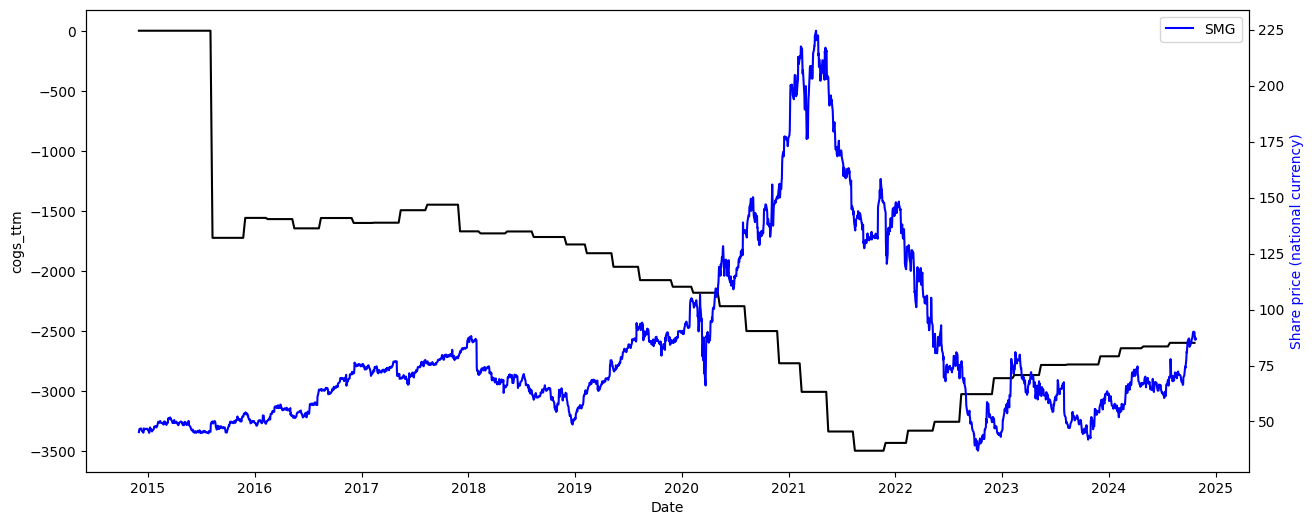

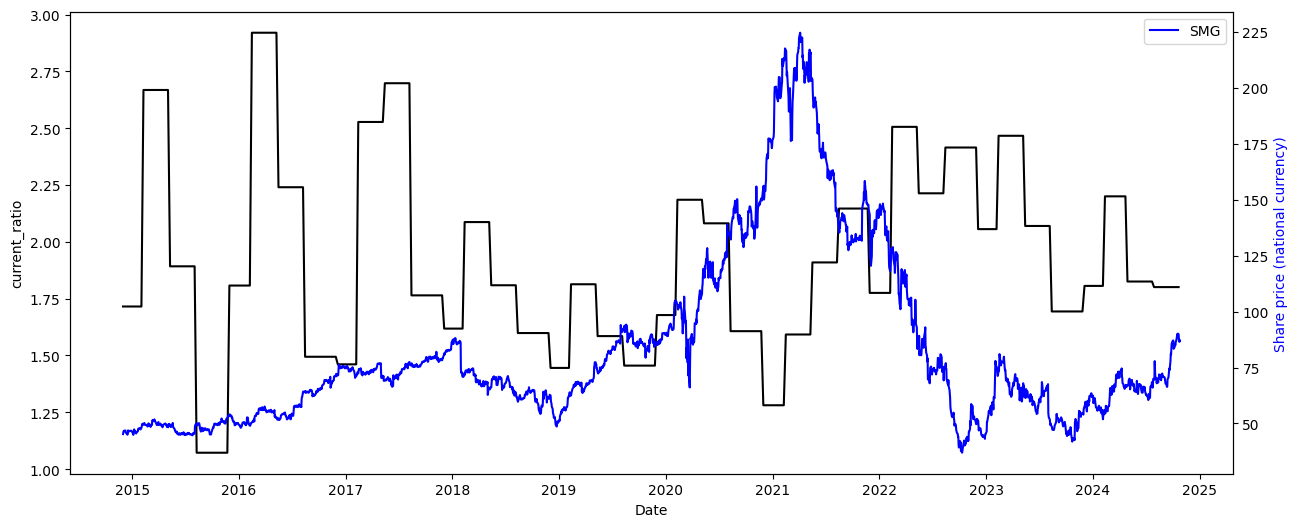

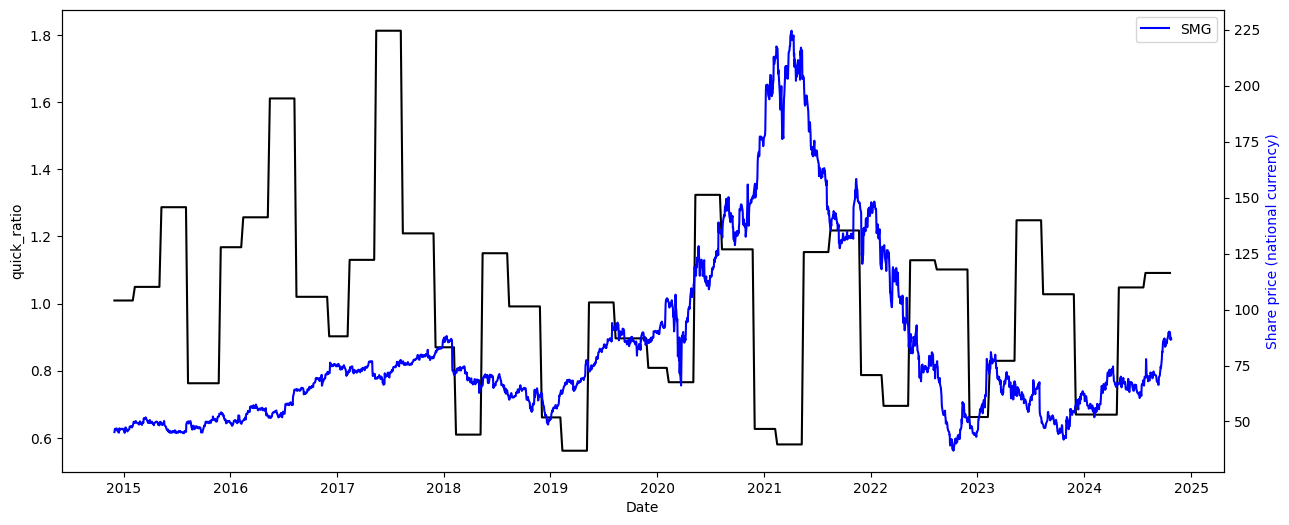

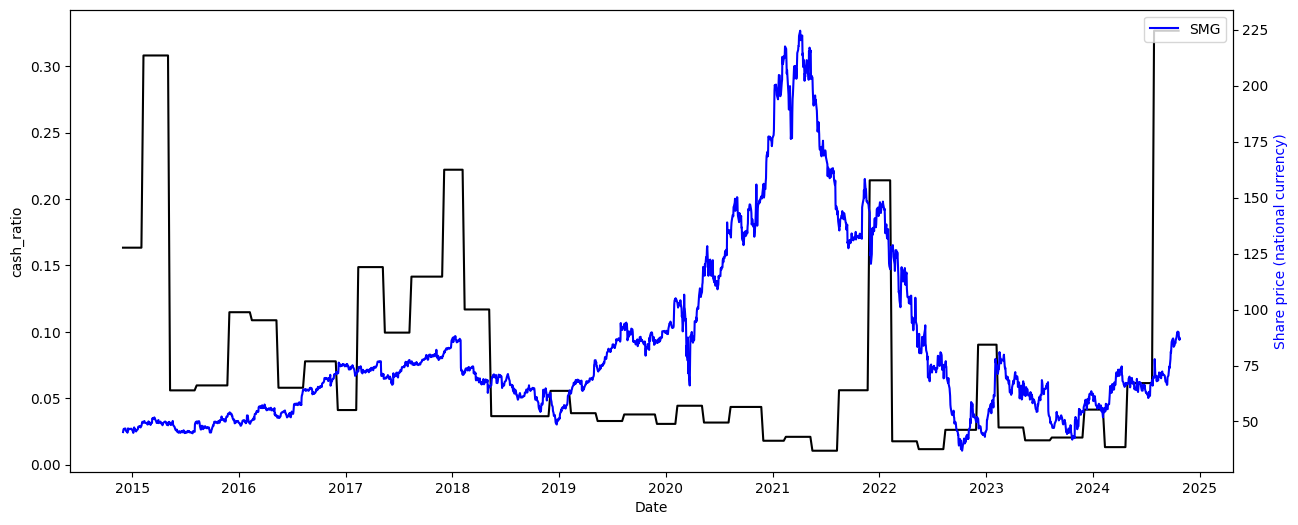

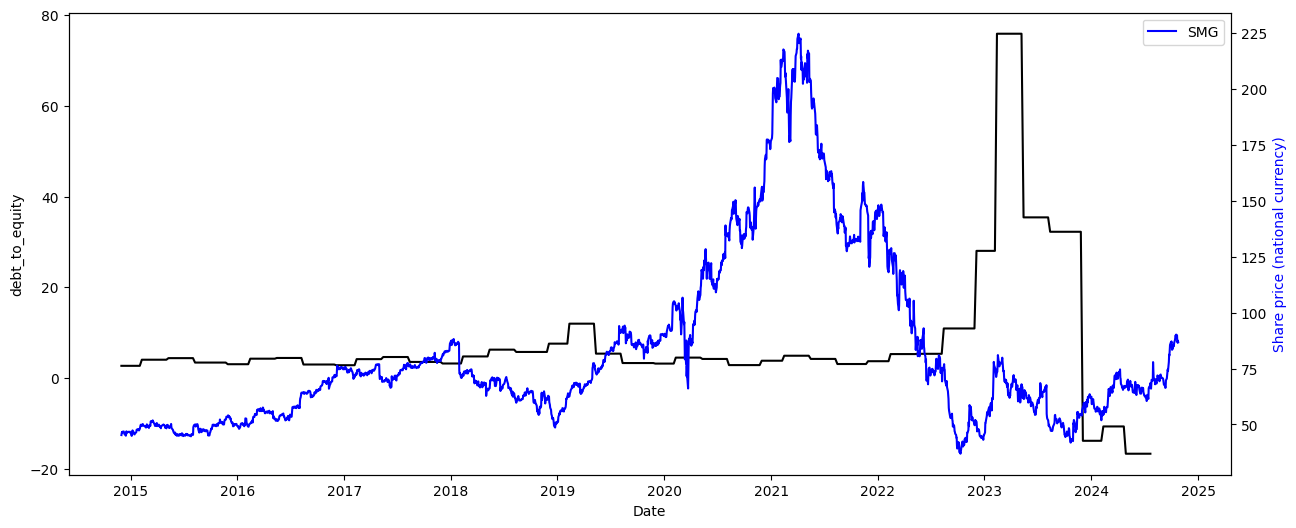

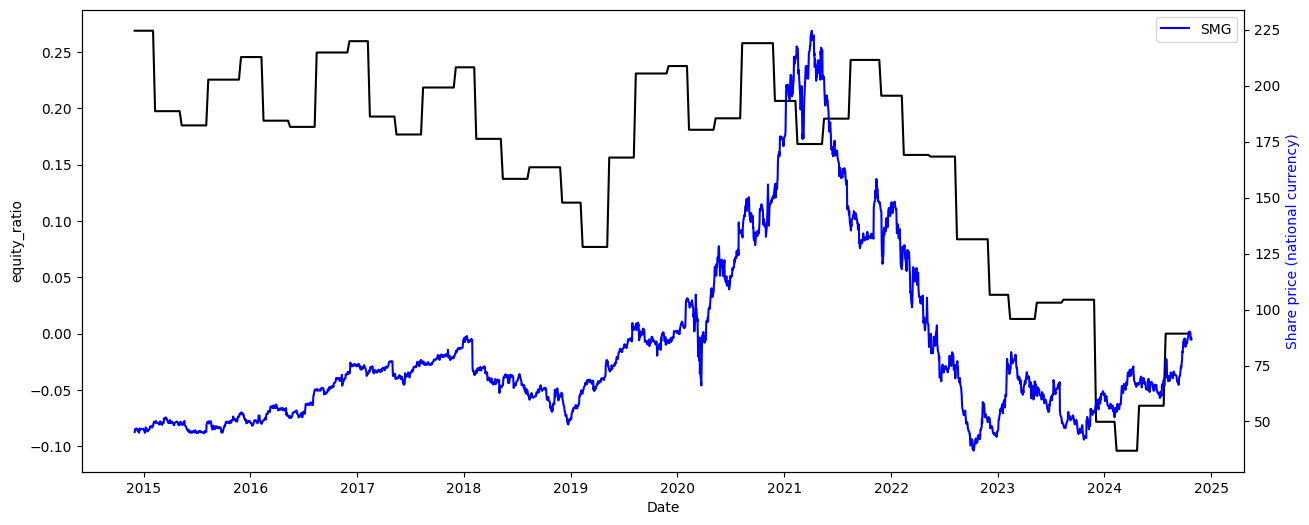

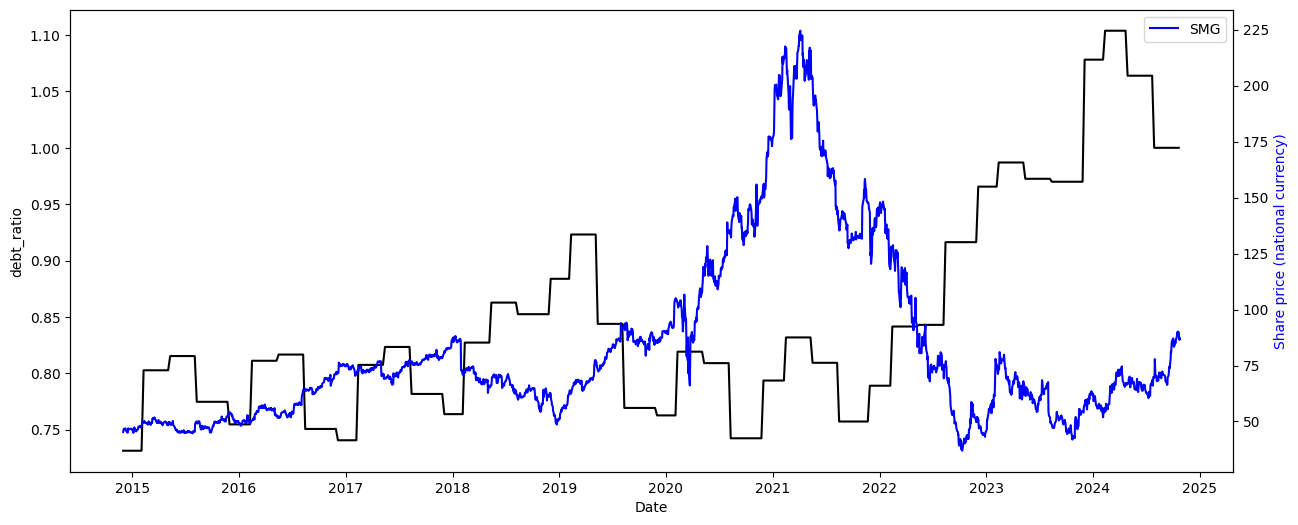

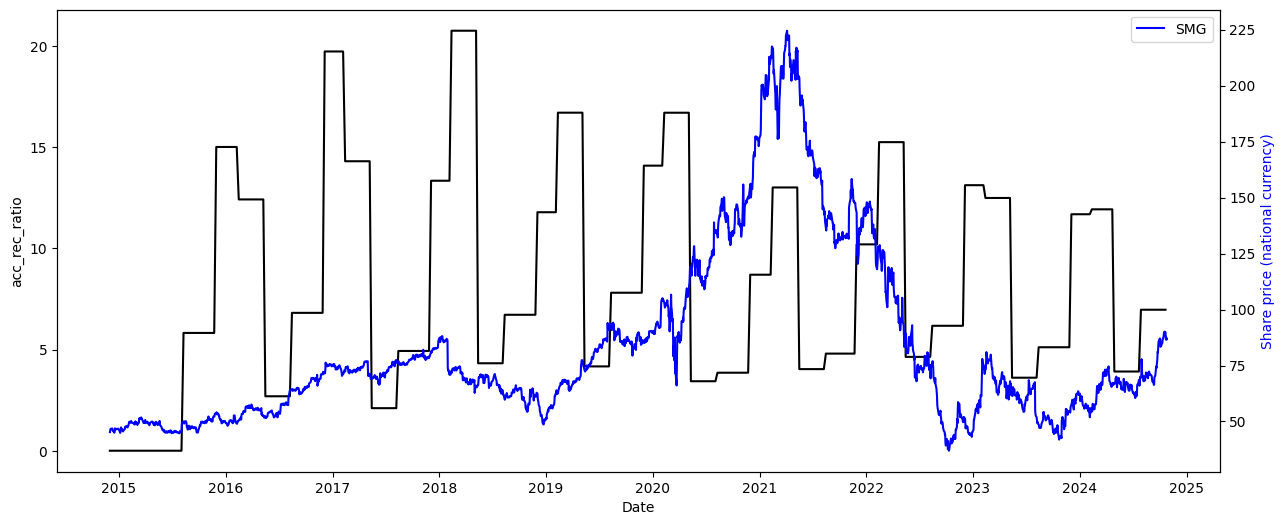

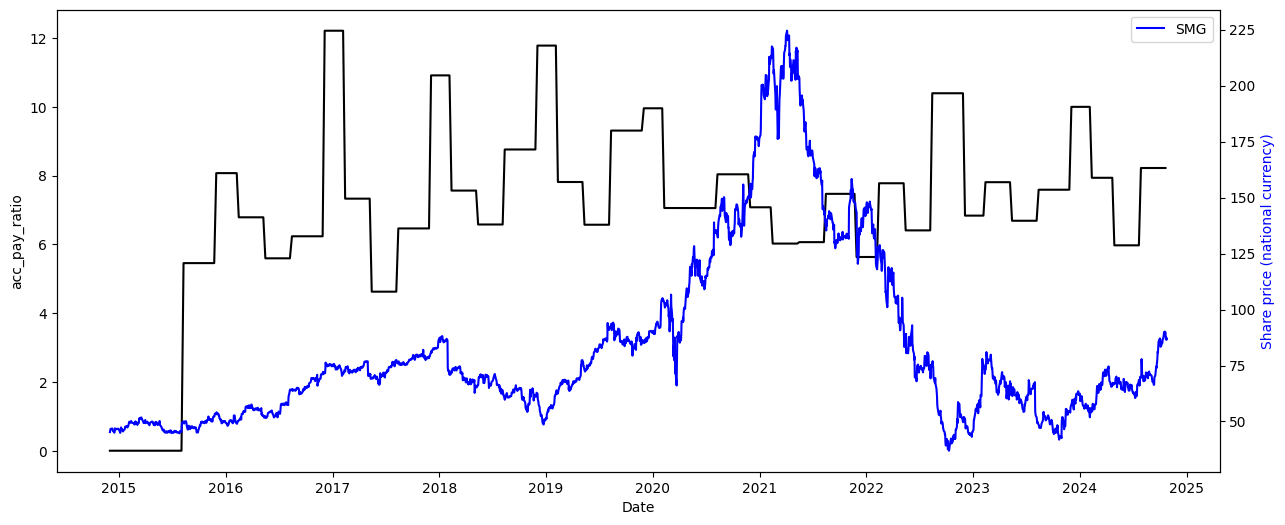

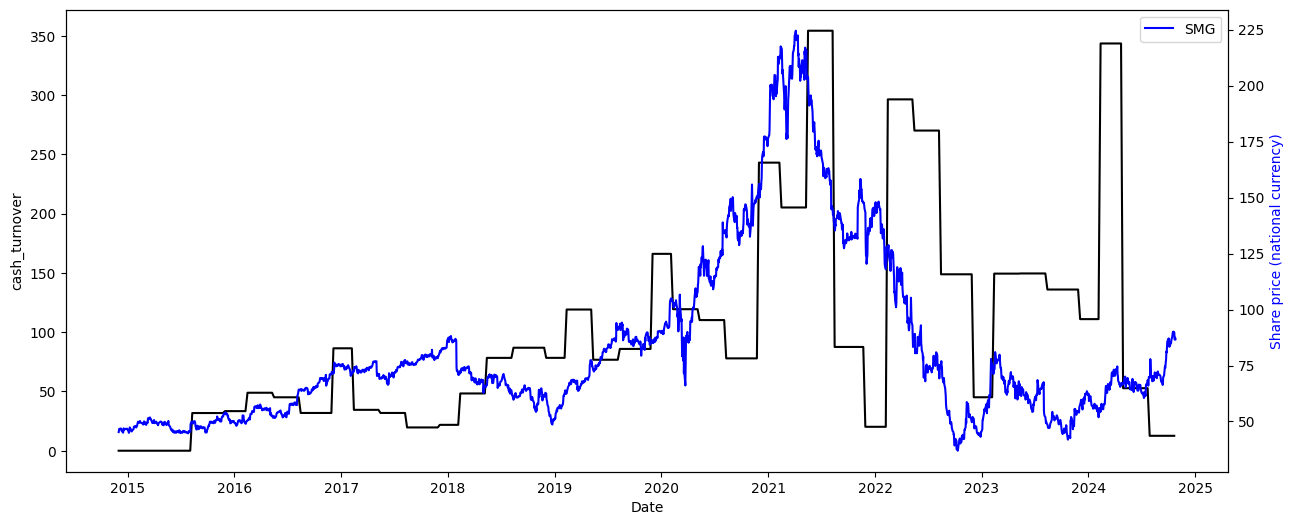

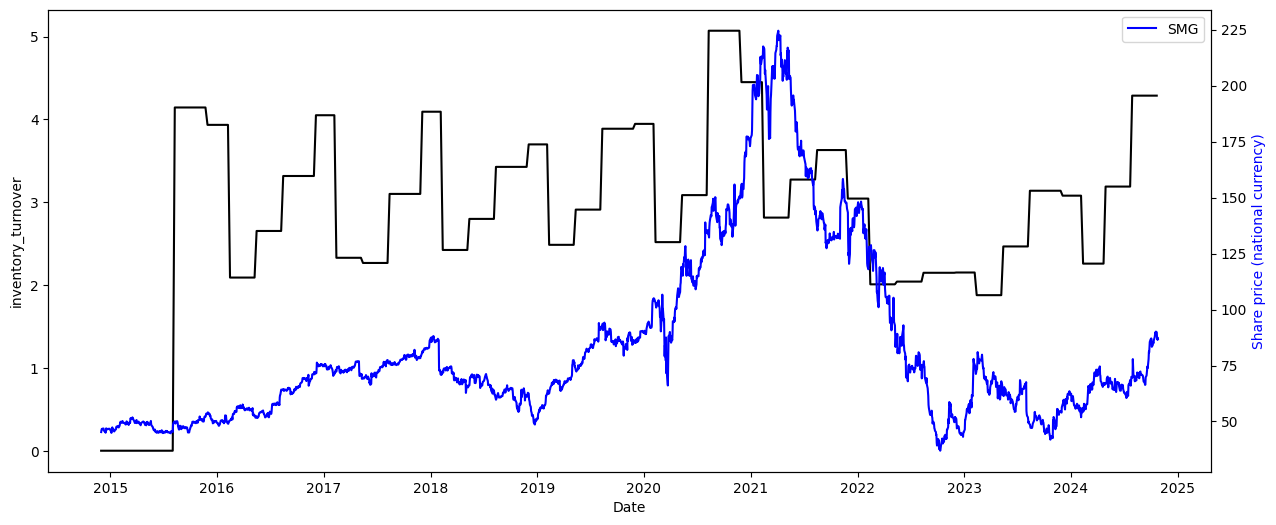

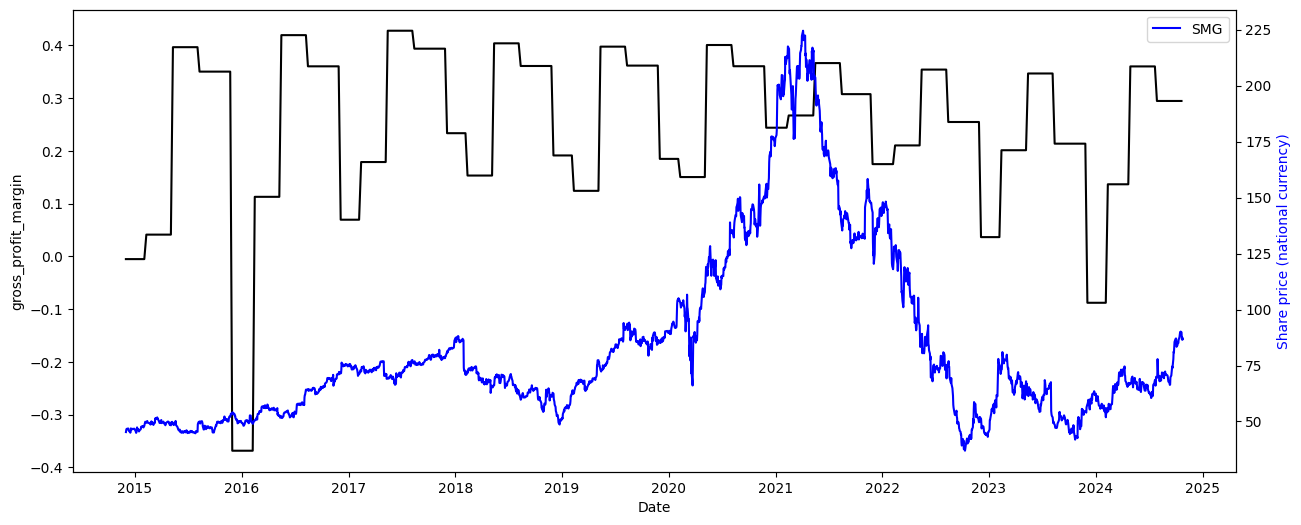

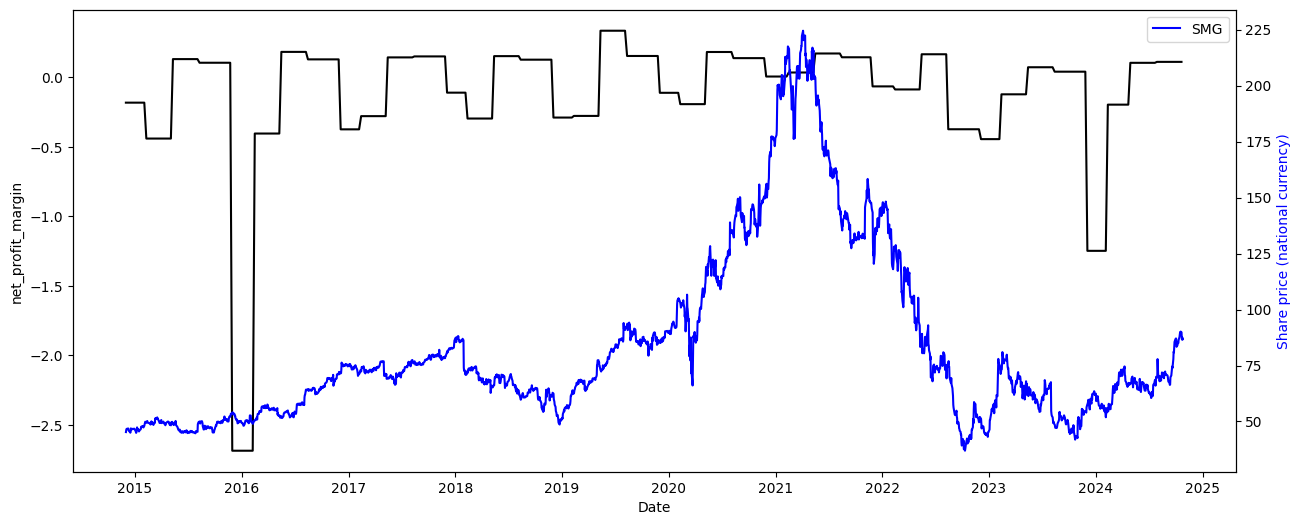

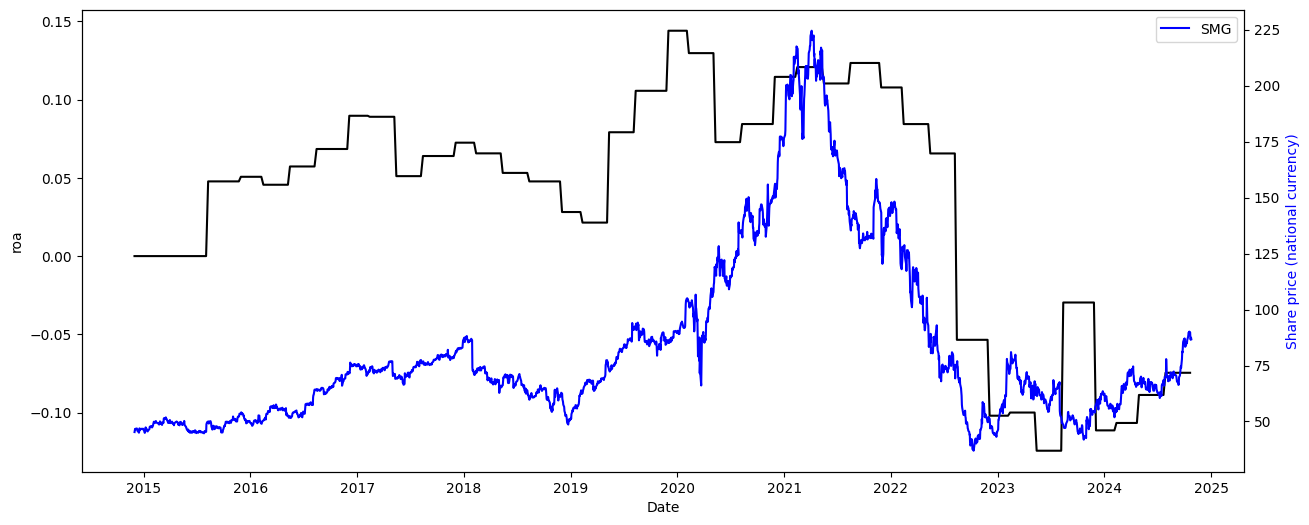

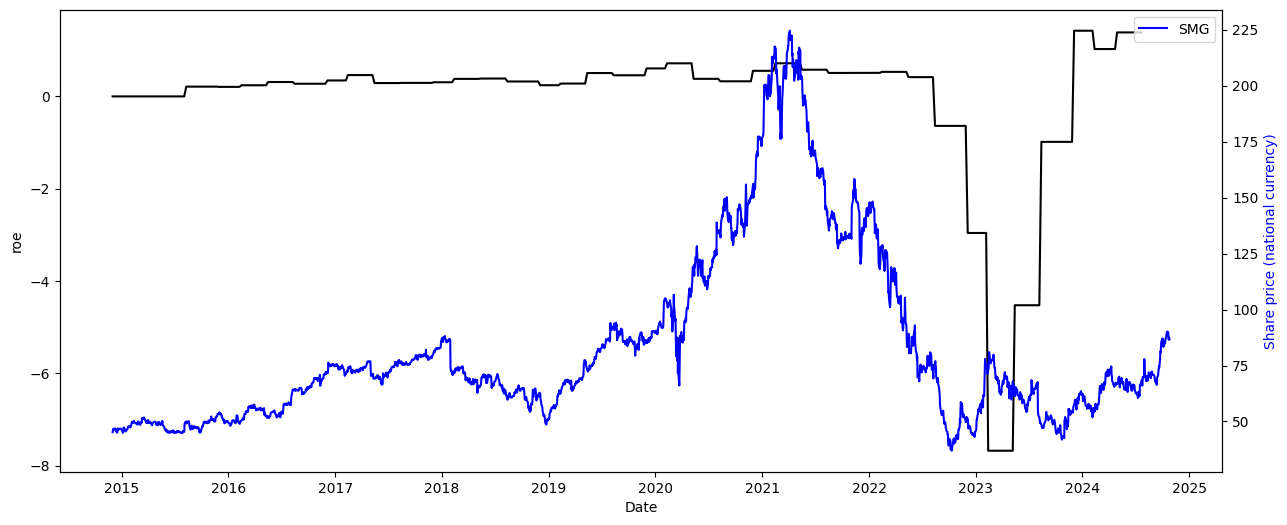

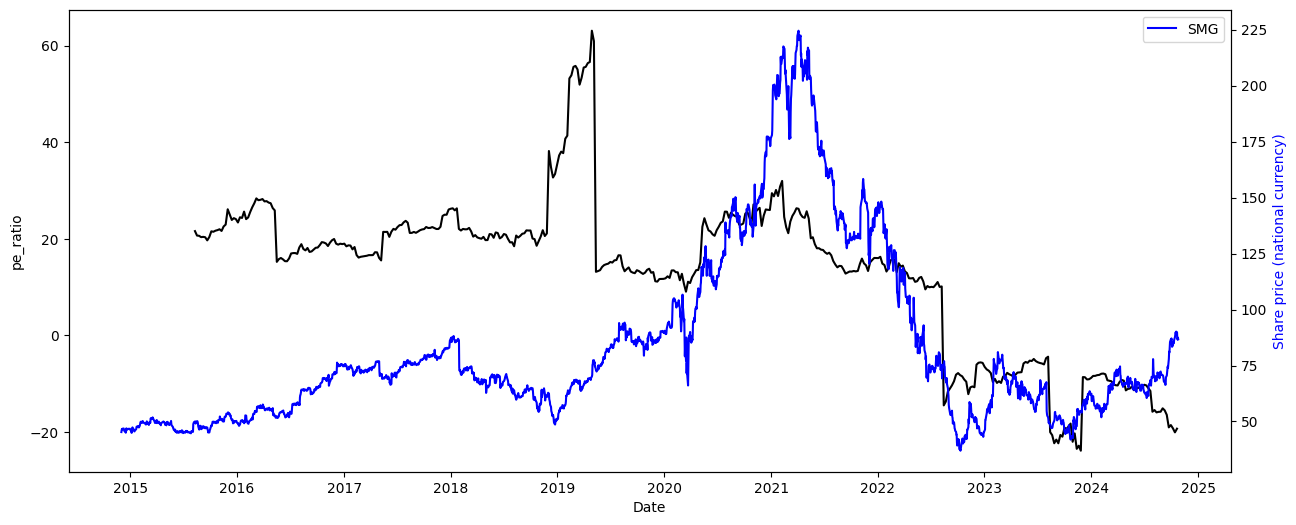

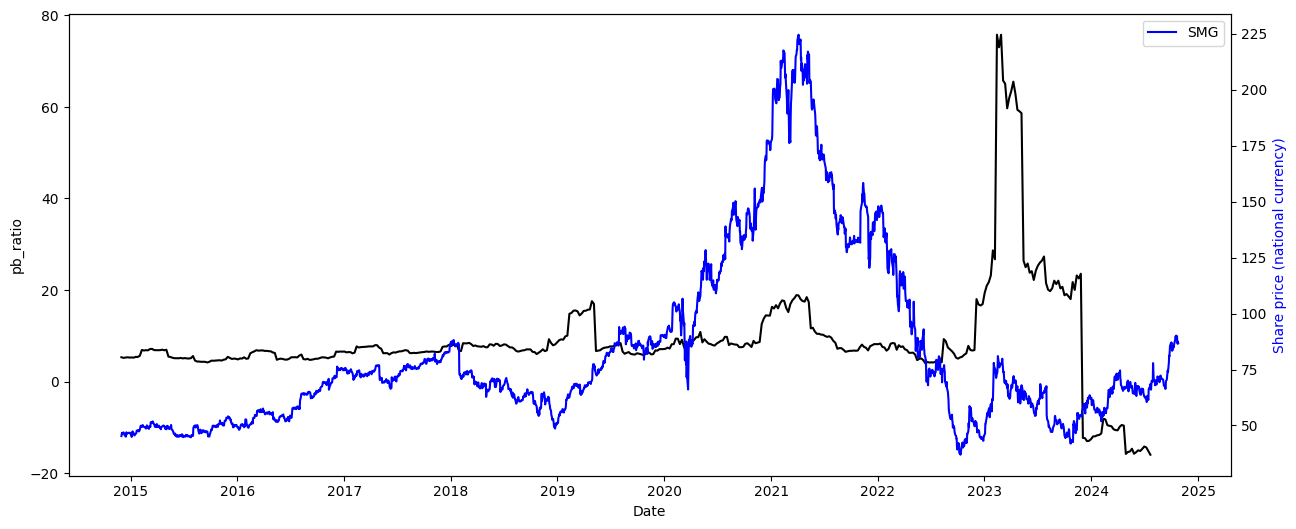

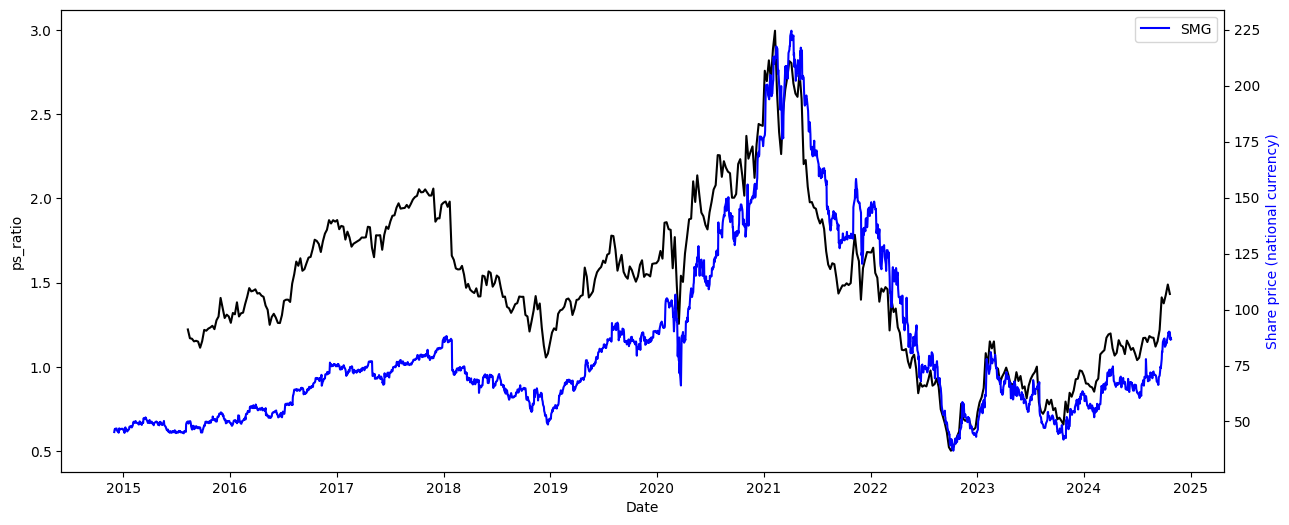

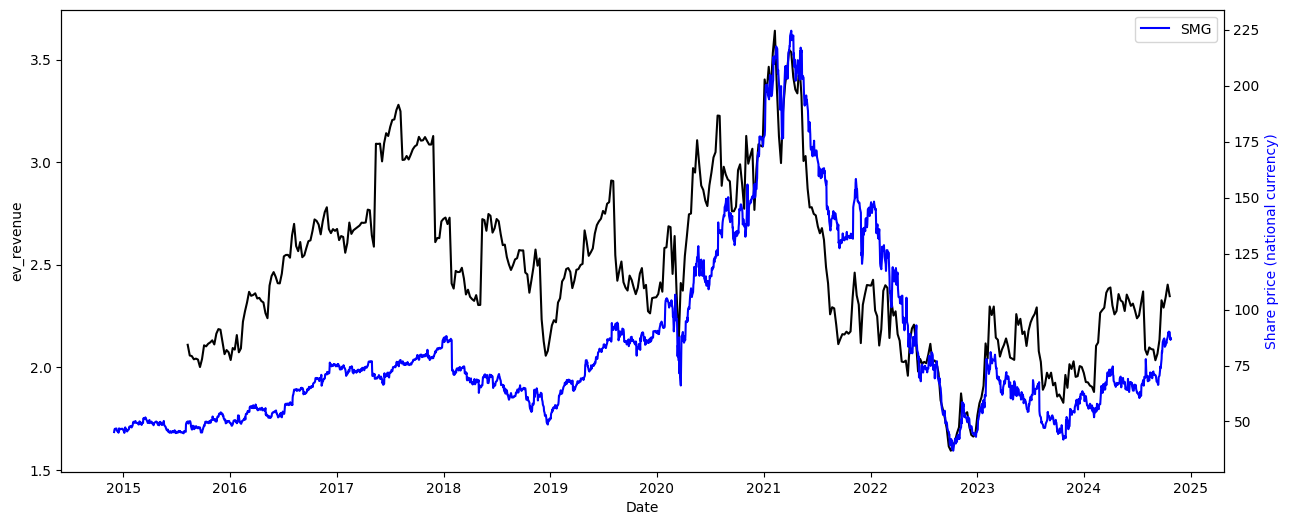

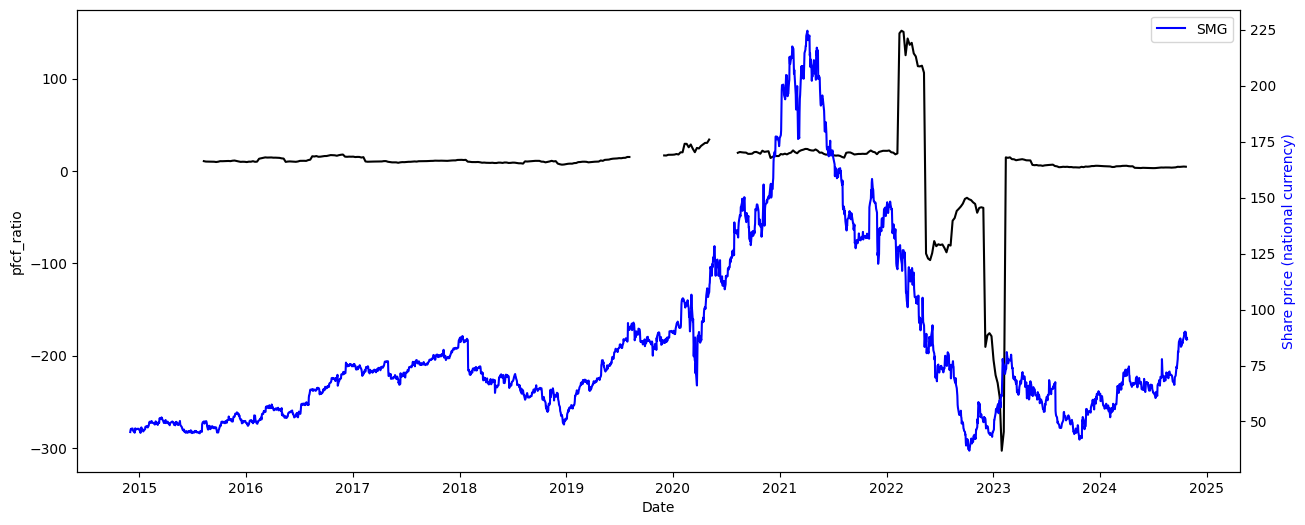

In [18]:
for column in merged_nat_curr.columns[3:]:
    fig, ax1 = plt.subplots(figsize=(15, 6))

    ax2 = ax1.twinx()
    ax1.plot(merged_nat_curr['real_date'], merged_nat_curr[column], color='k', label=merged_nat_curr)
    ax2.plot(ticker_all_price.index, ticker_all_price['Close'], color='b', label=share_name)

    ax1.set_xlabel('Date')
    ax1.set_ylabel(column, color='k')
    ax2.set_ylabel('Share price (national currency)', color='b')

    plt.legend()
    plt.show()

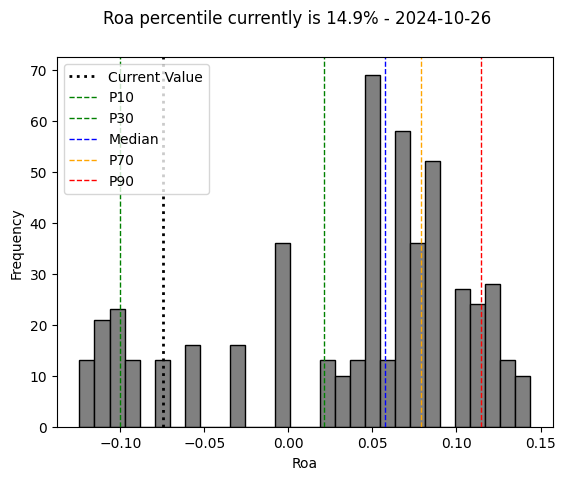

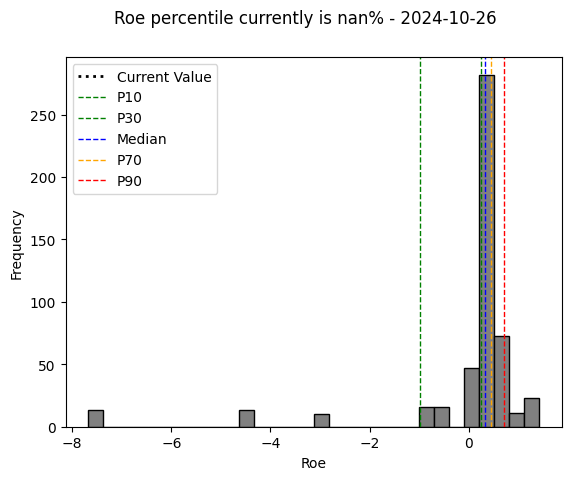

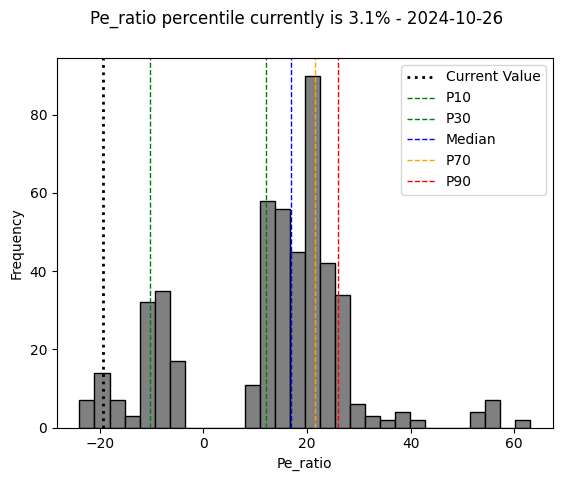

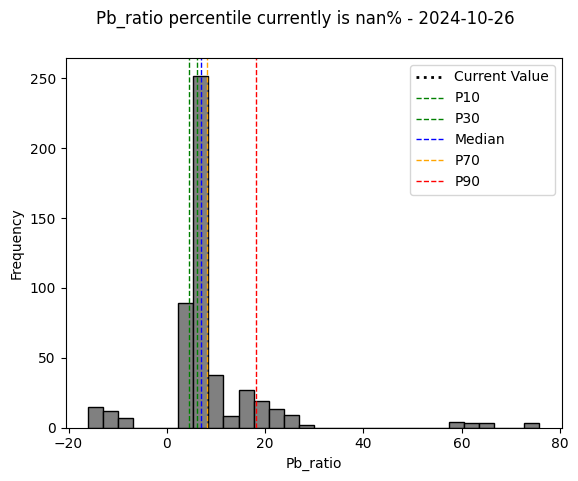

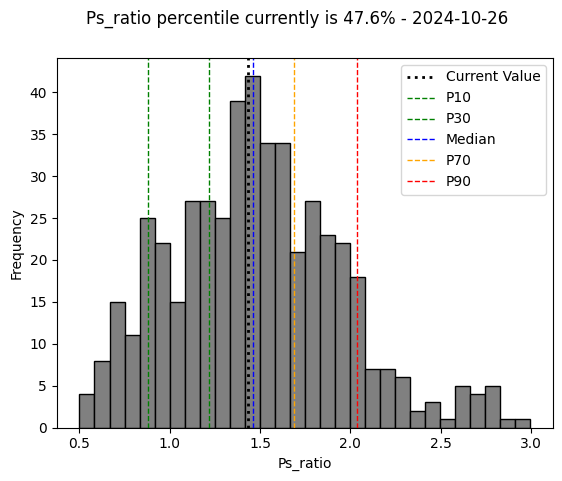

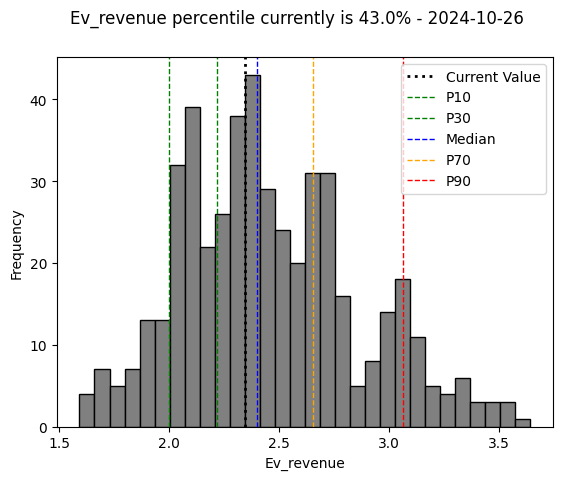

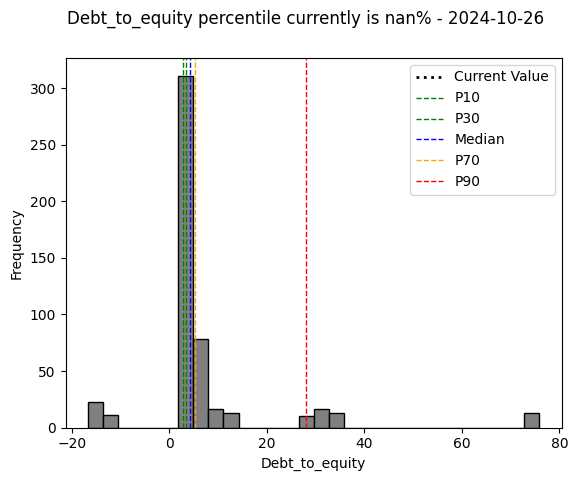

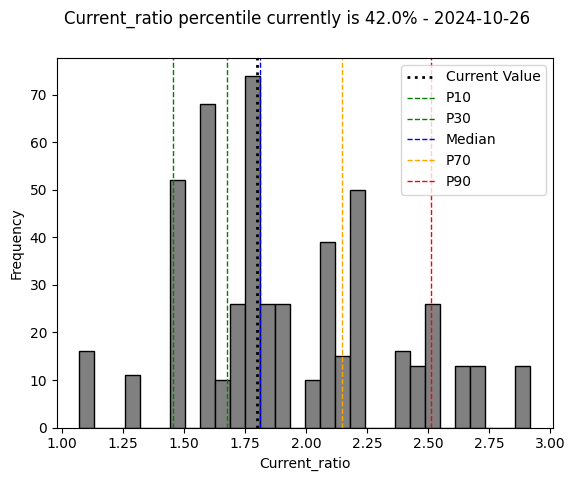

In [19]:
# plot histograms of value parameters
utils.plot_histogram_value_parameters(input_df=merged_nat_curr, extra_parameters=[], owned_shares=owned_shares)

## Calculate correlation between value parameters

In [20]:
# calulate value parameters Pearson's correlation coefficient
pd.DataFrame(merged_nat_curr, columns=['roa', 'roe', 'pe_ratio', 'pb_ratio', 'ps_ratio', 'ev_revenue', 'debt_to_equity', 'current_ratio']).corr()

,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,debt_to_equity,current_ratio
roa,1.000000,0.532355,0.670658,-0.145904,0.702349,0.545693,-0.360483,-0.205092
roe,0.532355,1.000000,0.390012,-0.863684,0.375998,0.299728,-0.941699,-0.224449
pe_ratio,0.670658,0.390012,1.000000,-0.095913,0.600120,0.550516,-0.305291,-0.186425
pb_ratio,-0.145904,-0.863684,-0.095913,1.000000,-0.043103,-0.022293,0.947316,0.129810
ps_ratio,0.702349,0.375998,0.600120,-0.043103,1.000000,0.929083,-0.319250,-0.254410
ev_revenue,0.545693,0.299728,0.550516,-0.022293,0.929083,1.000000,-0.256219,-0.160073
debt_to_equity,-0.360483,-0.941699,-0.305291,0.947316,-0.319250,-0.256219,1.000000,0.185141
current_ratio,-0.205092,-0.224449,-0.186425,0.129810,-0.254410,-0.160073,0.185141,1.000000


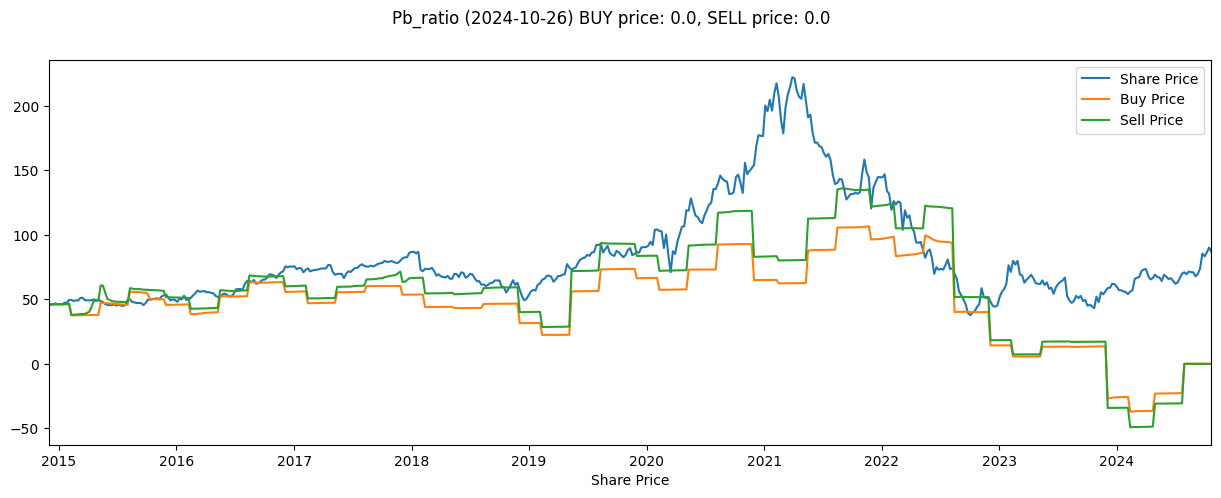

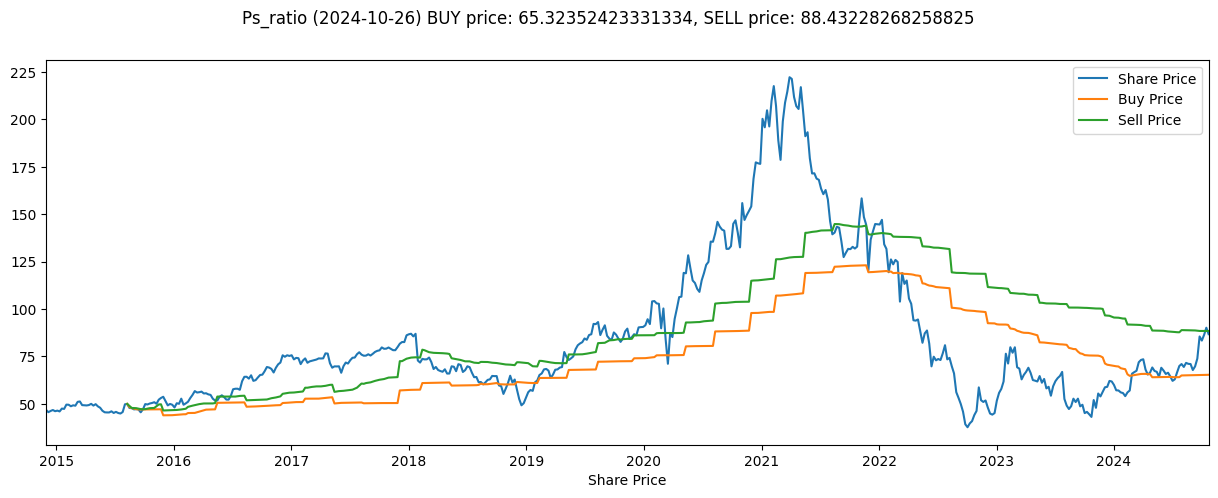

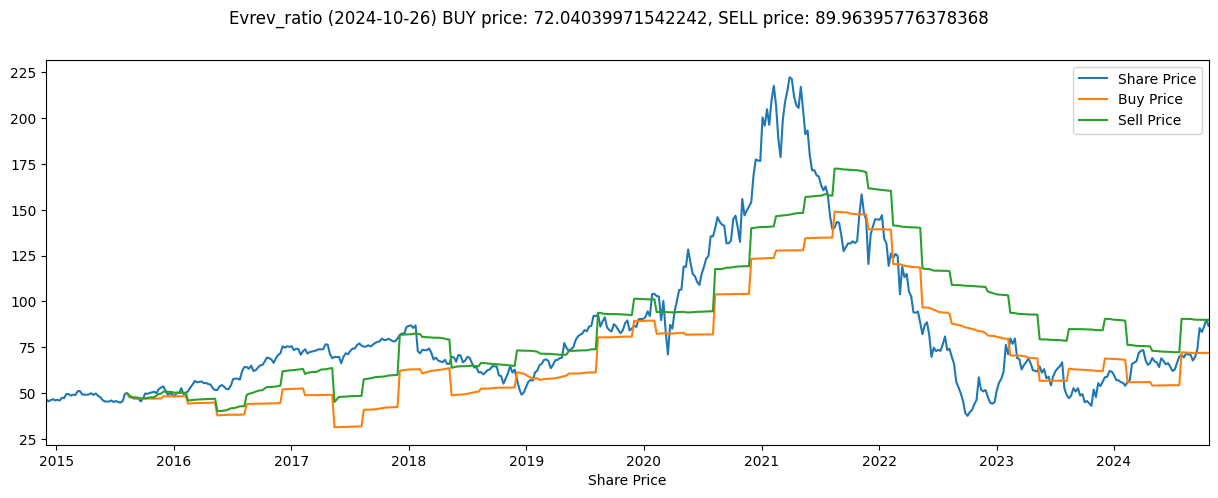

In [21]:
final_df = utils.get_value_stock_target_prices(
    input_df=merged_nat_curr,
    min_pct=0.2,
    max_pct=0.5,
    owned_shares=owned_shares
)